# Litteraturbanken Author 
version 1.20 -  added link json 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * video Swedish
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

#### Other sources we sync
* [Arken](https://github.com/salgo60/open-data-examples/blob/master/Arken.ipynb) 
  * WD [Property:P8899](https://www.wikidata.org/wiki/Property:P8899) 
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2021-03-02 12:51:55.418221


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
382,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1614253375292,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,"{'birthplace': [9.1775, 48.776111111], 'birthp...",NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888 entries, 0 to 3887
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 3888 non-null   object        
 1   wd_hos_Litteraturbanken  1925 non-null   object        
 2   authorid_norm            3888 non-null   object        
 3   show                     3888 non-null   bool          
 4   updated                  3227 non-null   datetime64[ns]
 5   imported                 3227 non-null   datetime64[ns]
 6   librisid                 2079 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 186.2+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     2760
False    1128
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2760 entries, 1 to 3887
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2760 non-null   object        
 1   wd_hos_Litteraturbanken  1908 non-null   object        
 2   authorid_norm            2760 non-null   object        
 3   show                     2760 non-null   bool          
 4   updated                  2315 non-null   datetime64[ns]
 5   imported                 2315 non-null   datetime64[ns]
 6   librisid                 1498 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 153.6+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:70]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,WetterhoffK,NaN,WetterhoffK,True,2022-02-22,2022-02-22,NaN
1,ÖstergrenCL,NaN,OstergrenCL,True,2021-03-01,2021-03-01,NaN
2,EngströmG,NaN,EngstromG,True,2021-03-01,2021-03-01,NaN
3,PhilipssonJ,Q52509398,PhilipssonJ,True,2021-03-01,2016-12-08,qn258h284sql3ht
4,PfeifferS,NaN,PfeifferS,True,2021-03-01,2021-03-01,tr57btrc06z9bbq
...,...,...,...,...,...,...,...
65,NilssonAlexander,NaN,NilssonAlexander,True,2021-03-01,2021-03-01,NaN
66,FuruhjelmAL,NaN,FuruhjelmAL,True,2021-03-01,2021-03-01,NaN
67,FuruhjelmM,NaN,FuruhjelmM,True,2021-03-01,2021-03-01,dbqsnxnx3fc3wwr
68,FåhræusOI,NaN,FahraeusOI,True,2021-03-01,2021-03-01,31fjn5bm30ktpr2


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:30]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,WetterhoffK,NaN,WetterhoffK,True,2022-02-22,2022-02-22,NaN
1,HazeliusA,NaN,HazeliusA,True,2021-03-01,2021-03-01,tr5783sc4n98v9q
2,HasselbergS,NaN,HasselbergS,True,2021-03-01,2021-03-01,NaN
3,LundequistS,NaN,LundequistS,True,2021-03-01,2021-03-01,1zcgkllk320v5s2
4,HackzellE,NaN,HackzellE,True,2021-03-01,2021-03-01,NaN
5,LönnbergM,NaN,LonnbergM,True,2021-03-01,2021-03-01,NaN
6,GötbergR,NaN,GotbergR,True,2021-03-01,2021-03-01,NaN
7,MeyerG,NaN,MeyerG,True,2021-03-01,2021-03-01,xv8bft9g1rdfznt
8,MeyerPJ,NaN,MeyerPJ,True,2021-03-01,2021-03-01,NaN
9,GoveniusLJ,NaN,GoveniusLJ,True,2021-03-01,2021-03-01,rp351df947k8x52


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1920 non-null   object
 1   authorid    1920 non-null   object
dtypes: object(2)
memory usage: 30.1+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    2
authorid      2
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("WahlinKr")]

,WikidataID,authorid
1796,Q100997902,WahlinKr


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1920,NaN,WetterhoffK,NaN,WetterhoffK,True,2022-02-22,2022-02-22,NaN,Litterturbanken_only
2539,NaN,Anonym,NaN,Anonym,True,2021-03-01,2007-06-18,NaN,Litterturbanken_only
2052,NaN,BjörckED,NaN,BjorckED,True,2021-03-01,2021-03-01,qn246jq83c7kw7x,Litterturbanken_only
2050,NaN,AhlgrenssonF,NaN,AhlgrenssonF,True,2021-03-01,2021-03-01,NaN,Litterturbanken_only
2049,NaN,BjörckJH,NaN,BjorckJH,True,2021-03-01,2021-03-01,NaN,Litterturbanken_only
2048,NaN,BothénG,NaN,BothenG,True,2021-03-01,2021-03-01,0xbdgb3j3jfph3m,Litterturbanken_only
2047,NaN,AfzeliusAJ,NaN,AfzeliusAJ,True,2021-03-01,2021-03-01,vs6895cd54hmhjz,Litterturbanken_only
2046,NaN,ÖbergE,NaN,ObergE,True,2021-03-01,2021-03-01,xv8chg2g12624t3,Litterturbanken_only
2045,NaN,BergstrandPE,NaN,BergstrandPE,True,2021-03-01,2021-03-01,sq461s4b4p31gmq,Litterturbanken_only
2044,NaN,BerndtsonC,NaN,BerndtsonC,True,2021-03-01,2021-03-01,khwz16132rtn9kh,Litterturbanken_only


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2780 entries, 1920 to 2779
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1920 non-null   object        
 1   authorid                 2780 non-null   object        
 2   wd_hos_Litteraturbanken  1908 non-null   object        
 3   authorid_norm            2760 non-null   object        
 4   show                     2760 non-null   object        
 5   updated                  2315 non-null   datetime64[ns]
 6   imported                 2315 non-null   datetime64[ns]
 7   librisid                 1498 non-null   object        
 8   WD_Litteraturbanken      2780 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 217.2+ KB


### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [19]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1900
Litterturbanken_only     860
WD_only                   20
Name: WD_Litteraturbanken, dtype: int64

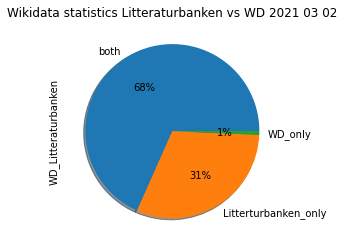

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [21]:
mergeCheckNumber

both                    1900
Litterturbanken_only     860
WD_only                   20
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [22]:
#mergewithLibris

In [23]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [24]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 2052 to 1442
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1246 non-null   object        
 1   authorid                 1498 non-null   object        
 2   wd_hos_Litteraturbanken  1245 non-null   object        
 3   authorid_norm            1498 non-null   object        
 4   show                     1498 non-null   object        
 5   updated                  1498 non-null   datetime64[ns]
 6   imported                 1498 non-null   datetime64[ns]
 7   librisid                 1498 non-null   object        
 8   WD_Litteraturbanken      1498 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 117.0+ KB


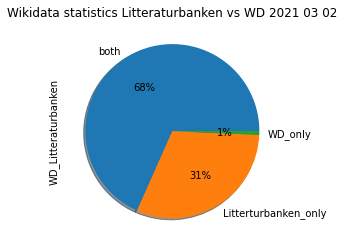

In [25]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [26]:
mergeCheckNumber

both                    1900
Litterturbanken_only     860
WD_only                   20
Name: WD_Litteraturbanken, dtype: int64

In [27]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 1910
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               20 non-null     object        
 1   authorid                 20 non-null     object        
 2   wd_hos_Litteraturbanken  0 non-null      object        
 3   authorid_norm            0 non-null      object        
 4   show                     0 non-null      object        
 5   updated                  0 non-null      datetime64[ns]
 6   imported                 0 non-null      datetime64[ns]
 7   librisid                 0 non-null      object        
 8   WD_Litteraturbanken      20 non-null     object        
dtypes: datetime64[ns](2), object(7)
memory usage: 1.6+ KB


In [28]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2760 non-null   object        
 1   wd_hos_Litteraturbanken  1908 non-null   object        
 2   authorid_norm            2760 non-null   object        
 3   show                     2760 non-null   bool          
 4   updated                  2315 non-null   datetime64[ns]
 5   imported                 2315 non-null   datetime64[ns]
 6   librisid                 1498 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 132.2+ KB


In [29]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2779 entries, 0 to 2778
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 20 non-null     object        
 1   authorid_x                 20 non-null     object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        20 non-null     object        
 9   authorid_y                 2760 non-null   object        
 10  wd_hos_Litteraturbanken_y  1908 non-null   object        
 11  authorid_norm_y            2760 non-null   object        
 12  show_y

In [30]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

In [31]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [32]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 

1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [33]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,authorid_x,show_y,authorid_y,WikidataID
0,TidstromK,True,TidströmK,Q105727505


In [34]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

,WikidataID,authorid,Littbank
0,Q105674275,336,link
77,Q5556719,AndrénV,link
120,Q36322,AustenJ,link
177,Q100776235,BerggrenH,link
215,Q68117,BirchPfeifferC,link
231,Q11859217,BjörkmanE,link
236,Q42011057,BjörnbergE,link
329,Q14932468,ButenschönA,link
447,Q100414371,DobbinL,link
733,Q4003029,HallbergP,link


In [35]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [36]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 1 non-null      object        
 1   authorid_x                 1 non-null      object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        1 non-null      object        
 9   Littbank                   1 non-null      object        
 10  authorid_y                 1 non-null      object        
 11  wd_hos_Litteraturbanken_y  0 non-null      object        
 12  authorid_nor

In [37]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q105727505,TidstromK,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,TidströmK,NaN,TidstromK,True,NaT,NaT,NaN,both


In [38]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [39]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1900
Litterturbanken_only     860
WD_only                   20
Name: WD_Litteraturbanken, dtype: int64

In [40]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860 entries, 1920 to 2779
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 860 non-null    object        
 2   wd_hos_Litteraturbanken  10 non-null     object        
 3   authorid_norm            860 non-null    object        
 4   show                     860 non-null    object        
 5   updated                  620 non-null    datetime64[ns]
 6   imported                 620 non-null    datetime64[ns]
 7   librisid                 252 non-null    object        
 8   WD_Litteraturbanken      860 non-null    object        
dtypes: datetime64[ns](2), object(7)
memory usage: 67.2+ KB


In [41]:
Litterturbanken_only.to_csv("LitteraturbankenAuthor_new.csv")
# LitteraturbankenAuthor_new.csv

In [42]:
#Litterturbanken_only

* See latest checked [LitteraturbankenAuthor_new.csv in GITHUB](https://github.com/salgo60/open-data-examples/blob/master/LitteraturbankenAuthor_new)

In [43]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                   0
authorid                   252
wd_hos_Litteraturbanken      0
authorid_norm              252
show                       252
updated                    252
imported                   252
librisid                   252
WD_Litteraturbanken        252
dtype: int64

## Errors funna nedan 
* Show True borde det inte vara False?: Eugénie BerglindhU EngeströmL Rafael WestinF 
* Dublett: NordinCG / NordinC , ArfvidssonN / ArfwidssonN 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [44]:
#Litterturbanken_only.head()

In [45]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy() 
Litterturbanken_onlyW["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
HTML(Litterturbanken_onlyW.to_html(escape=False))


,WikidataID,librisid,show,authorid,WD_Litteraturbanken,Littbank,LittbankJSON
2052,NaN,qn246jq83c7kw7x,True,BjörckED,Litterturbanken_only,link Litteraturbanken,json
2048,NaN,0xbdgb3j3jfph3m,True,BothénG,Litterturbanken_only,link Litteraturbanken,json
2047,NaN,vs6895cd54hmhjz,True,AfzeliusAJ,Litterturbanken_only,link Litteraturbanken,json
2046,NaN,xv8chg2g12624t3,True,ÖbergE,Litterturbanken_only,link Litteraturbanken,json
2045,NaN,sq461s4b4p31gmq,True,BergstrandPE,Litterturbanken_only,link Litteraturbanken,json
2044,NaN,khwz16132rtn9kh,True,BerndtsonC,Litterturbanken_only,link Litteraturbanken,json
2043,NaN,75knrb6r1gbvdl7,True,StackelbergO,Litterturbanken_only,link Litteraturbanken,json
2041,NaN,86lnq25s4wsbltk,True,BibergJF,Litterturbanken_only,link Litteraturbanken,json
2040,NaN,c9pswkvw2pzxbn2,True,SöderströmCEA,Litterturbanken_only,link Litteraturbanken,json
2038,NaN,mkz13kv52s58f9p,True,BernhardtG,Litterturbanken_only,link Litteraturbanken,json


In [46]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [47]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [48]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [49]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     1905
right_only    1113
both            15
Name: _merge, dtype: int64

In [50]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata
77,Q5556719,AndrénV,Q5556719,AndrenV,False,2019-10-16,2014-02-11,31fhkwkm15ph5nn,link Litteraturbanken,json,WD
120,Q36322,AustenJ,Q36322,AustenJ,False,2019-10-16,2014-02-11,gdsvwng02fdsq4t,link Litteraturbanken,json,WD
177,Q100776235,BerggrenH,Q100776235,BerggrenH,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
215,Q68117,BirchPfeifferC,Q68117,BirchPfeifferC,False,2019-05-14,2018-10-25,NaN,link Litteraturbanken,json,WD
231,Q11859217,BjörkmanE,Q11859217,BjorkmanE,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
236,Q42011057,BjörnbergE,Q42011057,BjornbergE,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
329,Q14932468,ButenschönA,Q14932468,ButenschonA,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
447,Q100414371,DobbinL,Q100414371,DobbinL,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
733,Q4003029,HallbergP,Q4003029,HallbergP,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
911,Q19794071,JonssonErnst,Q19794071,JonssonErnst,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD


In [51]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 77 to 1910
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               15 non-null     object        
 1   authorid                 15 non-null     object        
 2   wd_hos_Litteraturbanken  15 non-null     object        
 3   authorid_norm            15 non-null     object        
 4   show                     15 non-null     object        
 5   updated                  14 non-null     datetime64[ns]
 6   imported                 14 non-null     datetime64[ns]
 7   librisid                 4 non-null      object        
 8   Littbank                 15 non-null     object        
 9   LittbankJSON             15 non-null     object        
 10  Wikidata                 15 non-null     object        
dtypes: datetime64[ns](2), object(9)
memory usage: 1.4+ KB


In [52]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','ButenschönA','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','AndrénV','DobbinL','HallbergP','JonssonErnst',
                                    'WästbergA','LundströmM','WästbergA','NordlingS','BerggrenH','AustenJ',
                                             'BjörnbergE'
                                             
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))


## Problem records that has show false

In [53]:
ErrorShowFalseLitteraturbank["Litteraturbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + ErrorShowFalseLitteraturbank["authorid"] + "'>link</a>"
ErrorShowFalseLitteraturbank["get_author"] = "<a href='https://litteraturbanken.se/api/get_author/" + ErrorShowFalseLitteraturbank["authorid"] + "'>get_author</a>"

ErrorShowFalseLitteraturbank.sort_values(by=['authorid'],inplace=True, ascending=[True])
HTML(ErrorShowFalseLitteraturbank.to_html(escape=False))


,authorid,Litteraturbank,get_author
7,AndrénV,link,get_author
16,AustenJ,link,get_author
15,BerggrenH,link,get_author
0,BirchPfeifferC,link,get_author
1,BjörkmanE,link,get_author
17,BjörnbergE,link,get_author
2,ButenschönA,link,get_author
8,DobbinL,link,get_author
9,HallbergP,link,get_author
10,JonssonErnst,link,get_author


## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

**Lessom learned** we have bots that update from Litteraturbanken that sometimes add a mess....

In [54]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge


In [55]:
# Indicates that trhis member shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
15,NaN,WästbergA,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only
16,NaN,WästbergA,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only
17,NaN,LundströmM,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only


In [56]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

Ended:  2021-03-02 12:52:01.145093
Time elapsed (hh:mm:ass.ms) 0:00:05.727525
